In [111]:
%reload_ext autoreload
%autoreload 2

In [112]:
import sys
sys.path.append('..')

In [113]:
# output_path = 'output/init-sym-grid'
# output_path = 'output/init-clr-grad'
output_path = 'output/pretrain-sym-grid'
# output_path = 'output/pretrain-clr-grad'

texture_path = f'output/texture-sym-grid.png'
# texture_path = f'output/texture-clr-grad.png'

plot = True

## Dataset

In [114]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [115]:
from src.infra.registry import DATASET_REGISTRY
DATASET_REGISTRY

{'Dataset': torch.utils.data.dataset.Dataset,
 'SingleFaustDataset': src.dataset.shape_cor.SingleFaustDataset,
 'SingleScapeDataset': src.dataset.shape_cor.SingleScapeDataset,
 'SingleShrec19Dataset': src.dataset.shape_cor.SingleShrec19Dataset,
 'SingleSmalDataset': src.dataset.shape_cor.SingleSmalDataset,
 'SingleDT4DDataset': src.dataset.shape_cor.SingleDT4DDataset,
 'SingleShrec20Dataset': src.dataset.shape_cor.SingleShrec20Dataset,
 'SingleTopKidsDataset': src.dataset.shape_cor.SingleTopKidsDataset,
 'PairDataset': src.dataset.shape_cor.PairDataset,
 'PairFaustDataset': src.dataset.shape_cor.PairFaustDataset,
 'PairScapeDataset': src.dataset.shape_cor.PairScapeDataset,
 'PairShrec19Dataset': src.dataset.shape_cor.PairShrec19Dataset,
 'PairSmalDataset': src.dataset.shape_cor.PairSmalDataset,
 'PairDT4DDataset': src.dataset.shape_cor.PairDT4DDataset,
 'PairShrec20Dataset': src.dataset.shape_cor.PairShrec20Dataset,
 'PairShrec16Dataset': src.dataset.shape_cor.PairShrec16Dataset,
 'Pai

In [116]:
from src.utils.tensor import to_device

dataset = DATASET_REGISTRY['PairFaustDataset'](
    phase='train',
    data_root='../data/FAUST_r/',
    return_evecs='true',
    return_faces='true',
    num_evecs=200,
    return_corr='false',
    return_dist='false',
)

In [117]:
# sample
data = dataset[1]
data_x, data_y = to_device(data['first'], device), to_device(data['second'], device)
data_x['name'], data_y['name']

('tr_reg_000', 'tr_reg_001')

## Model components

### DiffusionNet feature extractor

In [118]:
import src
from src.infra.registry import MODEL_REGISTRY
MODEL_REGISTRY

{'Similarity': src.model.permutation.Similarity,
 'RegularizedFMNet': src.model.fmap.RegularizedFMNet,
 'DiffusionNet': src.model.diffusionnet.DiffusionNet}

In [119]:
feature_extractor = MODEL_REGISTRY['DiffusionNet'](
    in_channels=128,
    out_channels=256,
    cache_dir='../data/FAUST_r/diffusion',
    input_type='wks',
).to(device)
feature_extractor

DiffusionNet(
  (first_linear): Linear(in_features=128, out_features=128, bias=True)
  (last_linear): Linear(in_features=128, out_features=256, bias=True)
  (blocks): ModuleList(
    (0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_linear_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_activation_000): ReLU()
        (miniMLP_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_activation_001): ReLU()
        (miniMLP_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_002): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): DiffusionNetBlock(
      (diffusion): LearnedTimeDiff

In [120]:
# load pretrain weights
if 'pretrain' in output_path:
    network_path = '../checkpoints/faust.pth'
    feature_extractor.load_state_dict(
        torch.load(network_path)['networks']['feature_extractor']
    )
    print(f'Loaded pretrain weights from {network_path}')

Loaded pretrain weights from ../checkpoints/faust.pth


In [121]:
feat_x = feature_extractor(
    data_x['verts'].unsqueeze(0),
    data_x['faces'].unsqueeze(0),
)

feat_y = feature_extractor(
    data_y['verts'].unsqueeze(0),
    data_y['faces'].unsqueeze(0),
)

feat_x.shape, feat_y.shape

(torch.Size([1, 4999, 256]), torch.Size([1, 5000, 256]))

In [122]:
# compare features computed from mesh and point cloud
feat_x_pcd = feature_extractor(
    data_x['verts'].unsqueeze(0),
    # data_x['faces'].unsqueeze(0),
)

(feat_x - feat_x_pcd).abs().mean()

tensor(1.4716, device='cuda:0', grad_fn=<MeanBackward0>)

### Funtional maps solver

In [123]:
fm_solver = MODEL_REGISTRY['RegularizedFMNet'](
    bidirectional=True,
).to(device)

fm_solver

RegularizedFMNet()

In [124]:
evals_x = data_x['evals']
evals_y = data_y['evals']
evecs_x = data_x['evecs']
evecs_y = data_y['evecs']
evecs_trans_x = data_x['evecs_trans']
evecs_trans_y = data_y['evecs_trans']

#### Eigen vectors

In [125]:
evecs_x.shape, evecs_trans_x.shape

(torch.Size([4999, 200]), torch.Size([200, 4999]))

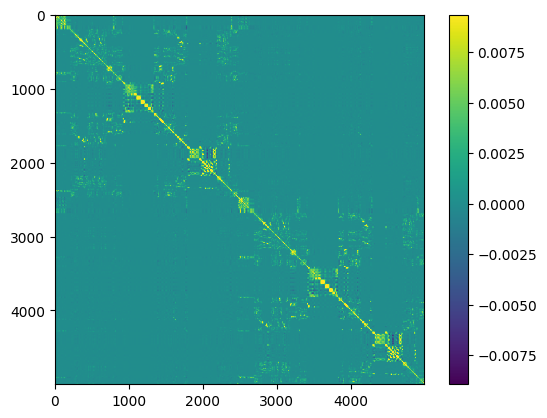

In [126]:
# verify eigen vectors' inverses
import matplotlib.pyplot as plt
from src.utils.tensor import to_numpy

if plot:
    mul = evecs_x @ evecs_trans_x
    plt.imshow(to_numpy(mul), vmin=mul.mean() - 3 * mul.std(), vmax=mul.mean() + 3 * mul.std())
    plt.colorbar()
    plt.show()

#### Functional maps

In [127]:
Cxy, Cyx = fm_solver(
    feat_x, feat_y,
    evals_x.unsqueeze(0),
    evals_y.unsqueeze(0),
    evecs_trans_x.unsqueeze(0),
    evecs_trans_y.unsqueeze(0),
)

Cxy.shape, Cyx.shape

(torch.Size([1, 200, 200]), torch.Size([1, 200, 200]))

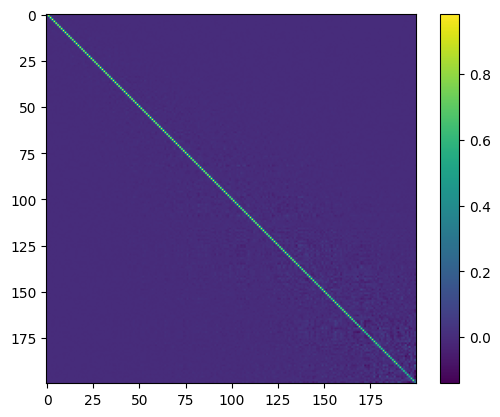

In [128]:
# verify inverse maps

if plot:
    plt.imshow(to_numpy((Cxy @ Cyx)[0]))
    plt.colorbar()
    plt.show()

### Point-wise correspondence matrix

In [129]:
permutation = MODEL_REGISTRY['Similarity'](
    tau=0.07,
)

In [130]:
import torch.nn.functional as F

similarity = torch.bmm(
    F.normalize(feat_x, dim=-1, p=2),
    F.normalize(feat_y, dim=-1, p=2).transpose(1, 2),
)

# sinkhorn normalization
Pxy = permutation(similarity)
Pyx = permutation(similarity.transpose(1, 2))

Pxy.shape, Pxy.min(), Pxy.max(), Pxy.mean(), Pxy.std()

(torch.Size([1, 4999, 5000]),
 tensor(7.5383e-11, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9192, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0046, device='cuda:0', grad_fn=<StdBackward0>))

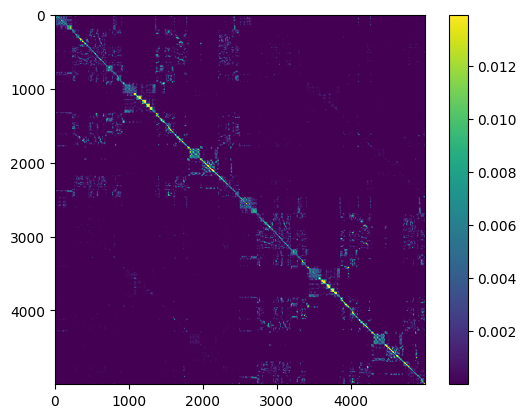

In [131]:
if plot:
    plt.imshow(to_numpy(Pxy), vmin=Pxy.min(), vmax=Pxy.mean() + 3 * Pxy.std())
    plt.colorbar()
    plt.show()

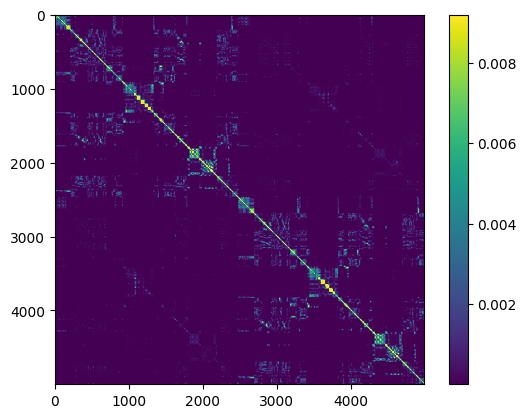

In [132]:
if plot:
    mul = Pxy @ Pyx
    plt.imshow(to_numpy(mul), vmin=mul.min(), vmax=mul.mean() + 3 * mul.std())
    plt.colorbar()
    plt.show()

## Pre-refine evaluation

### Loss

In [133]:
from src.infra.registry import LOSS_REGISTRY
dict = {}
LOSS_REGISTRY

{'MSELoss': torch.nn.modules.loss.MSELoss,
 'SquaredFrobeniusLoss': src.loss.fmap.SquaredFrobeniusLoss,
 'SURFMNetLoss': src.loss.fmap.SURFMNetLoss,
 'PartialFmapsLoss': src.loss.fmap.PartialFmapsLoss,
 'DirichletLoss': src.loss.dirichlet.DirichletLoss}

In [134]:
surfm_loss = LOSS_REGISTRY['SURFMNetLoss'](
    w_bij=1.0,
    w_orth=1.0,
    w_lap=0.0,
)
loss = surfm_loss(Cxy, Cyx, evals_x, evals_y)
dict['l_bij'] = loss['l_bij'].item()
dict['l_orth'] = loss['l_orth'].item()
dict

{'l_bij': 14.459869384765625, 'l_orth': 42.61013412475586}

In [135]:
align_loss = LOSS_REGISTRY['SquaredFrobeniusLoss'](
    loss_weight=1.0,
)

Cxy_est = torch.bmm(
    evecs_trans_y.unsqueeze(0),
    torch.bmm(Pyx, evecs_x.unsqueeze(0)),
)

Cyx_est = torch.bmm(
    evecs_trans_x.unsqueeze(0),
    torch.bmm(Pxy, evecs_y.unsqueeze(0)),
)

dict['align_loss'] = align_loss(Cxy, Cxy_est).item()
dict

{'l_bij': 14.459869384765625,
 'l_orth': 42.61013412475586,
 'align_loss': 25.855195999145508}

In [136]:
dirichlet_loss = LOSS_REGISTRY['DirichletLoss'](
    loss_weight=5,
)
Lx, Ly = data_x['L'], data_y['L']
dict['dirichlet_loss'] = dirichlet_loss(torch.bmm(Pxy, data_y['verts'].unsqueeze(0)), Lx.unsqueeze(0)).item()
dict

{'l_bij': 14.459869384765625,
 'l_orth': 42.61013412475586,
 'align_loss': 25.855195999145508,
 'dirichlet_loss': 29.742828369140625}

### Metric

In [137]:
from src.infra.registry import METRIC_REGISTRY
METRIC_REGISTRY

{'L1Loss': torch.nn.modules.loss.L1Loss,
 'MSELoss': torch.nn.modules.loss.MSELoss,
 'MeanDiffRatio': src.metric.stats.MeanDiffRatio,
 'StdDiffRatio': src.metric.stats.StdDiffRatio,
 'calculate_geodesic_error': <function src.metric.geodist.calculate_geodesic_error(dist_x, corr_x, corr_y, p2p, return_mean=True)>,
 'plot_pck': <function src.metric.geodist.plot_pck(geo_err, threshold=0.1, steps=40)>}

In [138]:
from src.utils.fmap import fmap2pointmap

p2p = fmap2pointmap(Cxy.squeeze(), evecs_x, evecs_y)
p2p.shape

torch.Size([5000])

In [139]:
geo_err = METRIC_REGISTRY['calculate_geodesic_error'](
    dist_x=to_numpy(data_x['dist']),
    corr_x=to_numpy(data_x['corr']),
    corr_y=to_numpy(data_y['corr']),
    p2p=to_numpy(p2p),
    return_mean=False,
)
dict['geo_err_mean'] = geo_err.mean()
dict

{'l_bij': 14.459869384765625,
 'l_orth': 42.61013412475586,
 'align_loss': 25.855195999145508,
 'dirichlet_loss': 29.742828369140625,
 'geo_err_mean': 0.015004672}

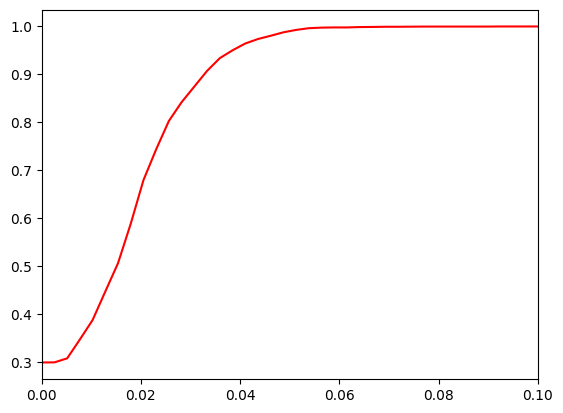

In [140]:
if plot:
    METRIC_REGISTRY['plot_pck'](geo_err)

In [141]:
import pandas as pd
pd.DataFrame(dict, index=['pre-refine'])

,l_bij,l_orth,align_loss,dirichlet_loss,geo_err_mean
pre-refine,14.459869,42.610134,25.855196,29.742828,0.015005


### Visualization

In [142]:
import os
import shutil

# copy texture file to output directory
if plot:
    os.makedirs(output_path, exist_ok=True)
    texture_fname = os.path.basename(texture_path)
    cp_texture_path = os.path.join(output_path, texture_fname)

    shutil.copy(
        texture_path,
        cp_texture_path,
    )

In [143]:
from src.utils.texture import write_obj_pair

# write the output obj files
if plot:
    name_x, name_y = data_x['name'], data_y['name']
    file_x = os.path.join(output_path, f'{name_x}.obj')
    file_y = os.path.join(output_path, f'{name_x}-{name_y}.obj')
    faces_x, faces_y = to_numpy(data_x['faces']), to_numpy(data_y['faces'])
    verts_x, verts_y = to_numpy(data_x['verts']), to_numpy(data_y['verts'])

    # compute the point-to-point map
    Cxy = evecs_trans_y @ evecs_x[p2p]
    Pyx = evecs_y @ Cxy @ evecs_trans_x

    write_obj_pair(file_x, file_y, verts_x, faces_x, verts_y, faces_y, to_numpy(Pyx), texture_fname)

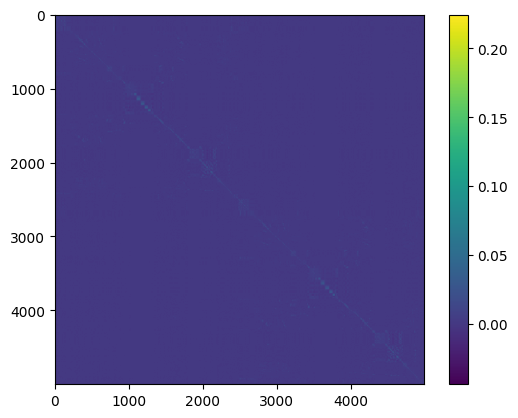

In [144]:
if plot:
    plt.imshow(to_numpy(Pyx))
    plt.colorbar()
    plt.show()

## Test-time adaption

In [145]:
def infer_single(data, feature_extractor, fm_solver, permutation):
    # data prep
    data_x, data_y = to_device(data['first'], device), to_device(data['second'], device)

    verts_x = data_x['verts'].unsqueeze(0)
    verts_y = data_y['verts'].unsqueeze(0)
    faces_x = data_x['faces'].unsqueeze(0)
    faces_y = data_y['faces'].unsqueeze(0)
    evals_x = data_x['evals'].unsqueeze(0)
    evals_y = data_y['evals'].unsqueeze(0)
    evecs_trans_x = data_x['evecs_trans'].unsqueeze(0)
    evecs_trans_y = data_y['evecs_trans'].unsqueeze(0)

    # feature extractor
    feat_x = feature_extractor(verts_x, faces_x)
    feat_y = feature_extractor(verts_y, faces_y)

    # fm solver
    Cxy, Cyx = fm_solver(
        feat_x, feat_y,
        evals_x,
        evals_y,
        evecs_trans_x,
        evecs_trans_y,
    )

    # point-wise correspondence
    similarity = torch.bmm(
        F.normalize(feat_x, dim=-1, p=2),
        F.normalize(feat_y, dim=-1, p=2).transpose(1, 2),
    )

    Pxy = permutation(similarity)
    Pyx = permutation(similarity.transpose(1, 2))

    return {
        'Cxy': Cxy,
        'Cyx': Cyx,
        'Pxy': Pxy,
        'Pyx': Pyx,
    }

In [146]:
infer = infer_single(data, feature_extractor, fm_solver, permutation)

In [147]:
def loss_single(data, infer, surfm_loss, align_loss, dirichlet_loss):
    # data prep
    data_x, data_y = to_device(data['first'], device), to_device(data['second'], device)

    verts_x = data_x['verts'].unsqueeze(0)
    verts_y = data_y['verts'].unsqueeze(0)
    evals_x = data_x['evals'].unsqueeze(0)
    evals_y = data_y['evals'].unsqueeze(0)
    evecs_x = data_x['evecs'].unsqueeze(0)
    evecs_y = data_y['evecs'].unsqueeze(0)
    evecs_trans_x = data_x['evecs_trans'].unsqueeze(0)
    evecs_trans_y = data_y['evecs_trans'].unsqueeze(0)
    Lx = data_x['L'].unsqueeze(0)
    Ly = data_y['L'].unsqueeze(0)

    Cxy = infer['Cxy']
    Cyx = infer['Cyx']
    Pxy = infer['Pxy']
    Pyx = infer['Pyx']

    dict = {}

    # surfmnet loss

    loss = surfm_loss(Cxy, Cyx, evals_x, evals_y)
    dict['l_bij'] = loss['l_bij']
    dict['l_orth'] = loss['l_orth']

    # alignment loss
    Cxy_est = torch.bmm(
        evecs_trans_y,
        torch.bmm(Pyx, evecs_x),
    )

    Cyx_est = torch.bmm(
        evecs_trans_x,
        torch.bmm(Pxy, evecs_y),
    )

    dict['align_loss_xy'] = align_loss(Cxy, Cxy_est)
    dict['align_loss_yx'] = align_loss(Cyx, Cyx_est)

    # dirichlet loss
    dict['dirichlet_loss_x'] = dirichlet_loss(torch.bmm(Pxy, verts_y), Lx)
    dict['dirichlet_loss_y'] = dirichlet_loss(torch.bmm(Pyx, verts_x), Ly)

    return dict

In [148]:
loss_single(data, infer, surfm_loss, align_loss, dirichlet_loss)

{'l_bij': tensor(14.6001, device='cuda:0', grad_fn=<MulBackward0>),
 'l_orth': tensor(42.8545, device='cuda:0', grad_fn=<MulBackward0>),
 'align_loss_xy': tensor(23.1006, device='cuda:0', grad_fn=<MulBackward0>),
 'align_loss_yx': tensor(25.5454, device='cuda:0', grad_fn=<MulBackward0>),
 'dirichlet_loss_x': tensor(36.3910, device='cuda:0', grad_fn=<MulBackward0>),
 'dirichlet_loss_y': tensor(43.0825, device='cuda:0', grad_fn=<MulBackward0>)}

In [149]:
import torch.optim as optim

optim_params = [
    {'params': feature_extractor.parameters(), 'lr': 1.0e-3},
    {'params': fm_solver.parameters(), 'lr': 1.0e-3},
    {'params': permutation.parameters(), 'lr': 1.0e-3},
]

optimizer = optim.Adam(
    optim_params,
)

In [150]:
for _ in range(100):
    infer = infer_single(data, feature_extractor, fm_solver, permutation)
    loss_dict = loss_single(data, infer, surfm_loss, align_loss, dirichlet_loss)

    optimizer.zero_grad()
    loss = 0

    for k, v in loss_dict.items():
        loss += v

    print(loss)

    loss.backward()
    optimizer.step()

tensor(179.4000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(179.9220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.8586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(186.9809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(170.1054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156.8728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(191.6237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(147.4883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(151.8810, device='cuda:0', grad_fn=<AddBackward0>)
tensor(164.5468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(167.2122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(172.2965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(167.5340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156.3990, device='cuda:0', grad_fn=<AddBackward0>)
tensor(148.3309, device='cuda:0', grad_fn=<AddBackward0>)
tensor(151.7941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(152.7606, device='cuda:0', grad_fn=<AddBackward0>)
tensor(149.881

In [151]:
p2p = fmap2pointmap(infer['Cxy'].squeeze(), evecs_x, evecs_y)
geo_err = METRIC_REGISTRY['calculate_geodesic_error'](
    dist_x=to_numpy(data_x['dist']),
    corr_x=to_numpy(data_x['corr']),
    corr_y=to_numpy(data_y['corr']),
    p2p=to_numpy(p2p),
    return_mean=False,
)
geo_err.mean()

0.012447376

In [152]:
output_path = os.path.join(output_path, 'refine')

In [153]:
os.makedirs(output_path, exist_ok=True)
texture_fname = os.path.basename(texture_path)
cp_texture_path = os.path.join(output_path, texture_fname)

shutil.copy(
    texture_path,
    cp_texture_path,
)

'output/pretrain-sym-grid/refine/texture-sym-grid.png'

In [158]:
name_x, name_y = data_x['name'], data_y['name']
file_x = os.path.join(output_path, f'{name_x}.obj')
file_y = os.path.join(output_path, f'{name_x}-{name_y}.obj')
faces_x, faces_y = to_numpy(data_x['faces']), to_numpy(data_y['faces'])
verts_x, verts_y = to_numpy(data_x['verts']), to_numpy(data_y['verts'])

# # compute the point-to-point map
Cxy = evecs_trans_y @ evecs_x[p2p]
Pyx = evecs_y @ Cxy @ evecs_trans_x

write_obj_pair(file_x, file_y, verts_x, faces_x, verts_y, faces_y, to_numpy(Pyx), texture_fname)